In [3]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# 读取河流缓冲区矢量数据（Shapefile）
river_buffer_gdf = gpd.read_file('../赣江河流统一缓冲区.shp')

# 打开栅格数据
with rasterio.open('../江西省人类活动强度.tif') as src:
    # 检查缓冲区与栅格数据的CRS是否一致
    if river_buffer_gdf.crs != src.crs:
        print(f"缓冲区CRS: {river_buffer_gdf.crs} 和栅格CRS: {src.crs} 不一致。转换为相同的CRS。")
        river_buffer_gdf = river_buffer_gdf.to_crs(src.crs)
        print(f"转换后的缓冲区CRS: {river_buffer_gdf.crs}")
    else:
        print("缓冲区和栅格的坐标参考系一致。")

    # 将缓冲区转换为GeoJSON格式
    buffer_json = river_buffer_gdf.geometry.__geo_interface__

    # 确保转换为GeoJSON的几何对象有效
    if 'features' in buffer_json and len(buffer_json['features']) > 0:
        print("GeoJSON格式的几何对象有效。")
    else:
        print("GeoJSON格式的几何对象无效，请检查转换。")
        print(buffer_json)

    # 使用缓冲区切割栅格数据
    try:
        out_image, out_transform = mask(src, river_buffer_gdf.geometry, crop=True)

        # 更新元数据以反映新的栅格大小
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # 保存切割后的栅格数据
        with rasterio.open('../切割后的栅格数据.tif', 'w', **out_meta) as dest:
            dest.write(out_image)
        print("栅格数据已根据缓冲区成功切割并保存。")
    except ValueError as e:
        print(f"切割栅格数据时出错: {e}")

缓冲区和栅格的坐标参考系一致。
GeoJSON格式的几何对象有效。
栅格数据已根据缓冲区成功切割并保存。


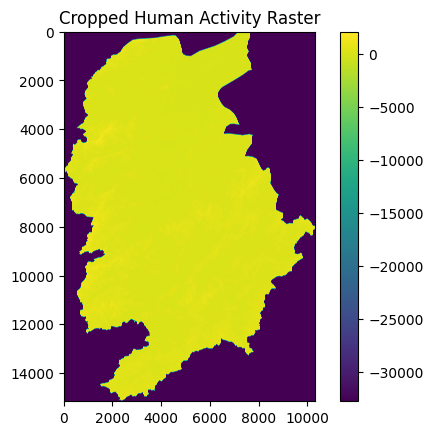

In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

# 第一步：加载赣江流域的Shapefile
shapefile_path = "../最新赣江流域范围.shp"
ganjiang_shp = gpd.read_file(shapefile_path)

# 第二步：加载人类活动强度的TIF文件
tif_path = "../江西省.tif"
with rasterio.open(tif_path) as src:
    # 将赣江流域Shapefile转换为GeoJSON格式
    ganjiang_geom = [feature["geometry"] for feature in ganjiang_shp.__geo_interface__["features"]]

    # 第三步：裁剪栅格数据，只保留赣江流域范围内的部分
    out_image, out_transform = mask(src, ganjiang_geom, crop=True)

    # 更新元数据以适应裁剪后的栅格文件
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # 第四步：保存裁剪后的TIF文件
    output_tif_path = "cropped_human_activity.tif"
    with rasterio.open(output_tif_path, "w", **out_meta) as dest:
        dest.write(out_image)

# 可视化裁剪后的栅格数据
with rasterio.open(output_tif_path) as cropped_src:
    plt.imshow(cropped_src.read(1), cmap='viridis')
    plt.colorbar()
    plt.title("Cropped Human Activity Raster")
    plt.show()
